# Build datasets for Pachyderm-Seldon demo

Raw Dataset https://archive.ics.uci.edu/ml/datasets/census+income

https://docs.seldon.io/projects/alibi/en/latest/examples/anchor_tabular_adult.html

In [1]:
import numpy as np
import pandas as pd
from alibi.datasets import fetch_adult
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import category_encoders as ce
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)


np.random.seed(112)

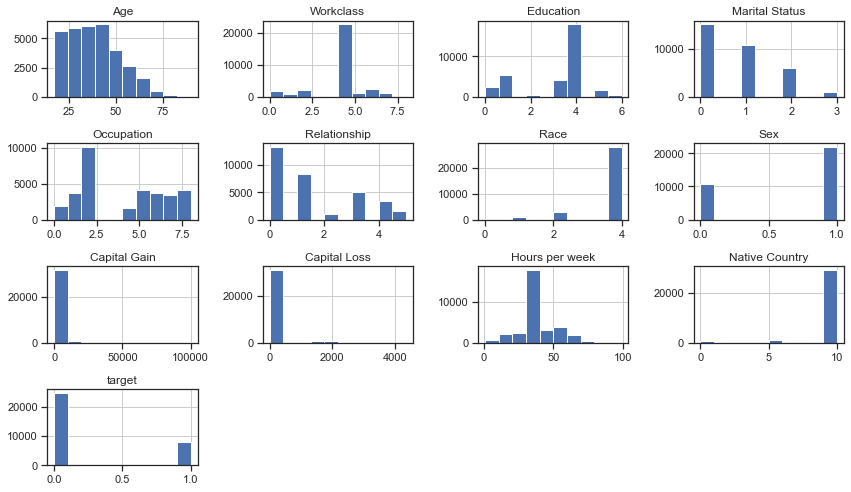

In [2]:
adult = fetch_adult()
adult.keys()

data = adult.data
target = adult.target
feature_names = adult.feature_names
category_map = adult.category_map

df = pd.DataFrame(data, columns=feature_names)
df['target'] = target
df = df.rename(columns={'Country': 'Native Country'})
df.head()

df.hist(figsize=(12, 7));
plt.tight_layout();

## Create V1

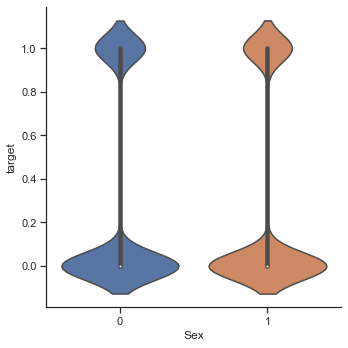

In [3]:
np.random.seed(112)

def sample_some_countries(group_df):
    country = group_df.head(1)['Native Country'].values[0]
    # US is 9
    if country == 1:
        return group_df.sample(1, random_state=112)
    elif country == 0:
        return group_df.sample(1, random_state=112)
    elif country == 2:
        return group_df.sample(1, random_state=112)
    elif country == 3:
        return group_df.sample(1, random_state=112)
    elif country == 4:
        return group_df.sample(1, random_state=112)
    elif country == 5:
        return group_df.sample(1, random_state=112)
    elif country == 6:
        return group_df.sample(1, random_state=112)
    elif country == 7:
        return group_df.sample(1, random_state=112)
    elif country == 8:
        return group_df.sample(1, random_state=112)
    elif country == 10:
        return group_df.sample(1, random_state=112)
    else:
        return group_df

# Focus on US market but keep some other entries
df_v1 = df[df['Capital Gain'] <= 10_000].groupby('Native Country').apply(lambda x: sample_some_countries(x)).droplevel(0)

# Balance gender
df_v1 = pd.concat([
    df_v1[df_v1['Sex'] == 1],
    df_v1[(df_v1['Sex'] == 0) & (df_v1['target'] == 1)].sample(6_000, replace=True, random_state=112),
    df_v1[(df_v1['Sex'] == 0) & (df_v1['target'] == 0)].sample(14_000, replace=True, random_state=112),
])

#df_v1.hist(figsize=(12, 7));
sns.catplot(x="Sex", y="target", data=df_v1, kind="violin")
plt.tight_layout();

In [4]:
encoder = ce.TargetEncoder(cols=['Education', 'Marital Status', 'Relationship', 'Occupation', 'Race', 'Sex', 'Native Country'])

def apply_target_encoder_to_cat_vars(df):
    """KSDrift requres categorial features to be Target-encoded."""
    X, y = df.drop(columns='target'), df['target']

    X_cont = X[['Age', 'Capital Gain', 'Capital Loss', 'Hours per week']]
    X_categ = X[['Education', 'Marital Status', 'Relationship', 'Occupation', 'Race', 'Sex', 'Native Country']]

    encoder.fit(X_categ, y)
    X_categ_new = encoder.transform(X_categ)

    return pd.concat([X_cont, X_categ_new, y], axis=1)

In [5]:
df_v1_final = apply_target_encoder_to_cat_vars(df_v1)
df_v1_final.to_csv('data/train_v1.csv')
df_v1_final.head()

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,Age,Capital Gain,Capital Loss,Hours per week,Education,Marital Status,Relationship,Occupation,Race,Sex,Native Country,target
14126,44,0,0,40,0.216500,0.538967,0.437123,0.361245,0.312640,0.2926,0.296403,0
12169,25,0,0,35,0.481587,0.078172,0.164608,0.527638,0.312640,0.2926,0.296403,0
12262,57,0,0,40,0.216500,0.538967,0.437123,0.178742,0.269327,0.2926,0.296403,1
16202,19,0,0,30,0.216500,0.078172,0.077253,0.242867,0.312640,0.2926,0.296403,0
13601,24,0,0,40,0.061501,0.078172,0.164608,0.070485,0.312640,0.2926,0.296403,0


## Pip modules check

In [6]:
!/Users/enricorotundo/anaconda3/envs/pachy/bin/python -c "import alibi; print(alibi.__version__)"

0.5.5


In [7]:
!/Users/enricorotundo/anaconda3/envs/pachy/bin/python -c "import alibi_detect; print(alibi_detect.__version__)"

0.4.3


In [8]:
!/Users/enricorotundo/anaconda3/envs/pachy/bin/python -c "import sklearn; print(sklearn.__version__)"

0.24.2


In [9]:
!/Users/enricorotundo/anaconda3/envs/pachy/bin/python -c "import dill; print(dill.__version__)"

0.3.3


## Train classifier on v1

In [10]:
!rm -rf _tmp/
!mkdir -p _tmp/v1

In [11]:
!cd IncomeTraining && /Users/enricorotundo/anaconda3/envs/pachy/bin/python income_train.py ../data/train_v1.csv ../_tmp/v1/model.joblib

Loading data set from ../data/train_v1.csv
Training model...
Model trained!
model coefficients:
           feature  coefficient
6     Relationship     3.925991
4        Education     3.765093
7       Occupation     3.107599
5   Marital Status     2.071264
3   Hours per week     0.026412
0              Age     0.023965
2     Capital Loss     0.000637
1     Capital Gain     0.000305
8             Race    -1.388124
9              Sex    -1.728093
10  Native Country    -1.762769
Train accuracy:  0.8316546762589928
Saving model in ../_tmp/v1/model.joblib
Model saved!


## Train Drift

In [12]:
!cd DriftTraining && /Users/enricorotundo/anaconda3/envs/pachy/bin/python drift_train.py ../data/train_v1.csv ../_tmp/v1/drift/

Loading data set from ../data/train_v1.csv
Creating drift detector...
Saving drift detector in ../_tmp/v1/drift/
Directory ../_tmp/v1/drift/ does not exist and is now created.
Drift detector saved!


In [52]:
# create test set for V1...
np.random.seed(112)
df_v1_final.sample(10).to_csv('data/test_drift_explain_v1.csv')

In [54]:
import json

df_test_drift_explain_v1 = pd.read_csv('data/test_drift_explain_v1.csv', index_col=0)

payload = {
    "data": {
        "names": df_test_drift_explain_v1.drop(columns='target').columns.values.tolist(),
        "ndarray": df_test_drift_explain_v1.drop(columns='target').values.tolist()
        
    }
}
request_json = json.dumps(payload)

with open("data/test_drift_explain_v1.json", "w") as outfile:
    outfile.write(request_json)

# payload['data']['names']
# #payload['data']['ndarray']
# #"ndarray": df_test_drift_explain_v1.drop(columns='target').values.tolist()

**No drift yet**

In [23]:
!cd DriftTraining && /Users/enricorotundo/anaconda3/envs/pachy/bin/python drift_test.py ../data/test_drift_explain_v1.csv ../_tmp/v1/drift/

       Age  Capital Gain  Capital Loss  ...     Sex  Native Country  target
6053    22             0             0  ...  0.3000        0.296435       0
16138   57             0          1602  ...  0.3000        0.296435       0
5864    48          3325             0  ...  0.2926        0.296435       0
5753    40             0             0  ...  0.3000        0.296435       0
23552   70             0             0  ...  0.2926        0.296435       1
28225   39             0             0  ...  0.3000        0.296435       0
27557   36             0             0  ...  0.2926        0.296435       0
2906    81          2062             0  ...  0.3000        0.296435       0
22244   34             0             0  ...  0.3000        0.296435       0
30692   49             0             0  ...  0.3000        0.296435       0

[10 rows x 12 columns]
{'data': {'is_drift': 0, 'distance': array([3.0059096e-01, 1.3815519e-01, 5.6089412e-02, 1.9331963e-01,
       1.9555499e-01, 2.3630524e-01,

## Train Explain v1

In [24]:
!mkdir -p _tmp/v1/explain
!cd ExplainerTraining && /Users/enricorotundo/anaconda3/envs/pachy/bin/python explainer_train.py ../data/train_v1.csv ../_tmp/v1/model.joblib ../_tmp/v1/explain 'foo_income_data_commit' 'foo_income_training_commit'

income_data_commit: foo_income_data_commit
income_training_commit: foo_income_training_commit
Loading income model from ../_tmp/v1/model.joblib
Loading data set from ../data/train_v1.csv
Training Explainer...
Explainer trained!
Saving explainer in ../_tmp/v1/explain
Explainer saved!


In [25]:
!cd ExplainerTraining && /Users/enricorotundo/anaconda3/envs/pachy/bin/python explainer_test.py ../data/test_drift_explain_v1.csv ../_tmp/v1/explain ../_tmp/v1/model.joblib

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 112, 'disc_perc': (25, 50, 75)}}
)
LogisticRegression(max_iter=1000, random_state=112)

Anchor: Relationship <= 0.16
Anchor: Relationship <= 0.16 AND Education <= 0.48
Anchor: Relationship <= 0.16
Anchor: Occupation <= 0.18 AND Education <= 0.22
Anchor: Occupation > 0.53 AND Relationship > 0.16 AND Age > 47.00
Anchor: Relationship <= 0.13 AND Marital Status <= 0.16
Anchor: Relationship <= 0.13
Anchor: Relationship <= 0.16
Anchor: Relationship <= 0.13 AND Marital Status <= 0.08
Anchor: Relationship <= 0.16 AND Marital Status <= 0.16


## V1 now drifts...

In [58]:
np.random.seed(112)
df_v1_test = apply_target_encoder_to_cat_vars(df[df['Native Country'] != 9]).sample(10)
df_v1_test.to_csv('data/test_drift2_v1.csv')
print(df_v1_test.shape)
df_v1_test.head()

(10, 12)


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,Age,Capital Gain,Capital Loss,Hours per week,Education,Marital Status,Relationship,Occupation,Race,Sex,Native Country,target
8871,29,0,0,35,0.045702,0.038949,0.053269,0.053726,0.123288,0.098255,0.250429,0
22614,38,0,0,40,0.474490,0.357587,0.370120,0.453172,0.123288,0.244570,0.250429,0
26577,35,0,0,45,0.134074,0.038949,0.081081,0.112290,0.188155,0.244570,0.337500,0
10182,39,0,0,26,0.134074,0.357587,0.370120,0.192308,0.188155,0.244570,0.250429,0
5083,25,0,0,40,0.134074,0.038949,0.081081,0.152648,0.123288,0.098255,0.062956,0


In [55]:
df_v1_test_explain_v1 = pd.read_csv('data/test_drift2_v1.csv', index_col=0)

payload = {
    "data": {
        "names": df_v1_test_explain_v1.drop(columns='target').columns.values.tolist(),
        "ndarray": df_v1_test_explain_v1.drop(columns='target').values.tolist()
        
    }
}
request_json = json.dumps(payload)

with open("data/test_drift2_v1.json", "w") as outfile:
    outfile.write(request_json)

In [56]:
!cd DriftTraining && /Users/enricorotundo/anaconda3/envs/pachy/bin/python drift_test.py ../data/test_drift2_v1.csv ../_tmp/v1/drift/

       Age  Capital Gain  Capital Loss  ...       Sex  Native Country  target
8871    29             0             0  ...  0.098255        0.250429       0
22614   38             0             0  ...  0.244570        0.250429       0
26577   35             0             0  ...  0.244570        0.337500       0
10182   39             0             0  ...  0.244570        0.250429       0
5083    25             0             0  ...  0.098255        0.062956       0
20175   27             0             0  ...  0.244570        0.196347       0
1969    45             0             0  ...  0.244570        0.196347       1
15587   48             0             0  ...  0.098255        0.062956       0
31466   24             0             0  ...  0.098255        0.075893       0
4913    23             0             0  ...  0.098255        0.335000       0

[10 rows x 12 columns]
{'data': {'is_drift': 1, 'distance': array([0.2401593 , 0.06667523, 0.0528777 , 0.16813977, 0.595555  ,
       0.7    

# Create V2

In [28]:
# unvder represent Males, and include a small fraction of OUTLIERS

np.random.seed(112)

df_us_female = pd.concat([
    df[(df['Sex'] == 0) & (df['target'] == 0) & (df['Age'] < 21)].sample(1_000, replace=True, random_state=112),
    df[(df['Sex'] == 0) & (df['target'] == 0) & (df['Age'] > 40)].sample(10, replace=True, random_state=112),
])
df_us_female

df_men = pd.concat([
    df[(df['Sex'] == 1) & (df['target'] == 1) & (df['Age'] < 21)].sample(5_000, replace=True, random_state=112),
    df[(df['Sex'] == 1) & (df['target'] == 1) & (df['Age'] > 40)].sample(10, replace=True, random_state=112),
])
df_men

                                                      
df_v2 = pd.concat([
    df_us_female,
    df_men
]).sample(frac=1)


encoder_v2 = ce.TargetEncoder(cols=['Education', 'Marital Status', 'Relationship', 'Occupation', 'Race', 'Sex', 'Native Country'])

def apply_target_encoder_to_cat_vars(df):
    """KSDrift requres categorial features to be Target-encoded."""
    X, y = df.drop(columns='target'), df['target']

    X_cont = X[['Age', 'Capital Gain', 'Capital Loss', 'Hours per week']]
    X_categ = X[['Education', 'Marital Status', 'Relationship', 'Occupation', 'Race', 'Sex', 'Native Country']]

    encoder_v2.fit(X_categ, y)
    X_categ_new = encoder_v2.transform(X_categ)

    return pd.concat([X_cont, X_categ_new, y], axis=1)

df_v2_final = apply_target_encoder_to_cat_vars(df_v2)
df_v2_final.to_csv('data/train_v2.csv')
df_v2_final

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,Age,Capital Gain,Capital Loss,Hours per week,Education,Marital Status,Relationship,Occupation,Race,Sex,Native Country,target
7741,19,0,0,60,0.944109,0.840054,0.966744,0.945716,0.850832,1.0,0.841062,1
7741,19,0,0,60,0.944109,0.840054,0.966744,0.945716,0.850832,1.0,0.841062,1
22660,19,0,0,40,0.004323,0.840054,0.000000,0.027397,0.850832,0.0,0.841062,0
7741,19,0,0,60,0.944109,0.840054,0.966744,0.945716,0.850832,1.0,0.841062,1
7741,19,0,0,60,0.944109,0.840054,0.966744,0.945716,0.850832,1.0,0.841062,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7741,19,0,0,60,0.944109,0.840054,0.966744,0.945716,0.850832,1.0,0.841062,1
7741,19,0,0,60,0.944109,0.840054,0.966744,0.945716,0.850832,1.0,0.841062,1
7741,19,0,0,60,0.944109,0.840054,0.966744,0.945716,0.850832,1.0,0.841062,1
24237,19,0,0,40,0.004323,0.840054,0.000000,0.005464,0.850832,0.0,0.841062,0


In [29]:
!rm -rf _tmp/v2/
!mkdir -p _tmp/v2/
!cd IncomeTraining && /Users/enricorotundo/anaconda3/envs/pachy/bin/python income_train.py ../data/train_v2.csv ../_tmp/v2/model.joblib

Loading data set from ../data/train_v2.csv
Training model...
Model trained!
model coefficients:
           feature  coefficient
9              Sex     4.473191
7       Occupation     2.430519
4        Education     2.348082
6     Relationship     1.150608
10  Native Country     0.431461
3   Hours per week     0.267288
5   Marital Status     0.215269
8             Race     0.128644
0              Age     0.091531
1     Capital Gain     0.000224
2     Capital Loss    -0.000987
Train accuracy:  0.9998338870431893
Saving model in ../_tmp/v2/model.joblib
Model saved!


# Test v2

In [30]:
# test v2

np.random.seed(112)

df_v2_test = df.loc[~df.index.isin(df_v2_final.index)]

df_v2_test = df_v2_test[(df_v2_test['Age'] > 50) & (df_v2_test['Capital Gain'] > 100) & (df_v2_test['Hours per week'] <= 10) & (df['Sex'] == 0) & (df['target'] == 0)]
#df_v2_test = df_v2_test[(df['target'] == 0)]

encoder_v2 = ce.TargetEncoder(cols=['Education', 'Marital Status', 'Relationship', 'Occupation', 'Race', 'Sex', 'Native Country'])

def apply_target_encoder_to_cat_vars(df):
    """KSDrift requres categorial features to be Target-encoded."""
    X, y = df.drop(columns='target'), df['target']

    X_cont = X[['Age', 'Capital Gain', 'Capital Loss', 'Hours per week']]
    X_categ = X[['Education', 'Marital Status', 'Relationship', 'Occupation', 'Race', 'Sex', 'Native Country']]

    encoder_v2.fit(X_categ, y)
    X_categ_new = encoder_v2.transform(X_categ)

    return pd.concat([X_cont, X_categ_new, y], axis=1)

df_v2_test = apply_target_encoder_to_cat_vars(df_v2_test)

df_v2_test.to_csv('data/test_v2.csv')
print(df_v2_test.shape)
df_v2_test.head()

(6, 12)


Boolean Series key will be reindexed to match DataFrame index.
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,Age,Capital Gain,Capital Loss,Hours per week,Education,Marital Status,Relationship,Occupation,Race,Sex,Native Country,target
2746,57,594,0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2906,81,2062,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4109,90,991,0,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6046,61,2414,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10303,69,2964,0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [59]:
df_v2_test = pd.read_csv('data/test_v2.csv', index_col=0)

payload = {
    "data": {
        "names": df_v2_test.drop(columns='target').columns.values.tolist(),
        "ndarray": df_v2_test.drop(columns='target').values.tolist()
        
    }
}
request_json = json.dumps(payload)

with open("data/test_v2.json", "w") as outfile:
    outfile.write(request_json)

## Outlier V2

In [31]:
!cd OutlierDetectorTraining/ && /Users/enricorotundo/anaconda3/envs/pachy/bin/python outlier_detector_training.py ../data/train_v2.csv ../_tmp/v2/outlier

Loading data set from ../data/train_v2.csv
No threshold level set. Need to infer threshold using `infer_threshold`.
Warming up detector...
Saving outlier detector in ../_tmp/v2/outlier
Directory ../_tmp/v2/outlier does not exist and is now created.
Outlier detector saved!


**Training set has almost no outliers..**

In [32]:
!cd OutlierDetectorTraining/ && /Users/enricorotundo/anaconda3/envs/pachy/bin/python outlier_detector_test.py ../data/train_v2.csv ../_tmp/v2/outlier

Mahalanobis
% outliers: 0.9634551495016611


**But test set has outliers**

In [33]:
!cd OutlierDetectorTraining/ && /Users/enricorotundo/anaconda3/envs/pachy/bin/python outlier_detector_test.py ../data/test_v2.csv ../_tmp/v2/outlier

Mahalanobis
% outliers: 100.0


### Explain V2

In [34]:
!mkdir -p _tmp/v2/explain
!cd ExplainerTraining && /Users/enricorotundo/anaconda3/envs/pachy/bin/python explainer_train.py ../data/train_v2.csv ../_tmp/v2/model.joblib ../_tmp/v2/explain 'foo_income_data_commit' 'foo_income_training_commit'

income_data_commit: foo_income_data_commit
income_training_commit: foo_income_training_commit
Loading income model from ../_tmp/v2/model.joblib
Loading data set from ../data/train_v2.csv
Training Explainer...
Explainer trained!
Saving explainer in ../_tmp/v2/explain
Explainer saved!


Explainer shows **Sex** feature is worringly relevant now.

In [35]:
!cd ExplainerTraining && /Users/enricorotundo/anaconda3/envs/pachy/bin/python explainer_test.py ../data/test_v2.csv ../_tmp/v2/explain ../_tmp/v2/model.joblib

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 112, 'disc_perc': (25, 50, 75)}}
)
LogisticRegression(max_iter=1000, random_state=112)

Anchor: Hours per week <= 60.00 AND Age > 19.00 AND Occupation <= 0.95 AND Relationship <= 0.97 AND Education <= 0.94 AND Capital Gain > 0.00
Anchor: Hours per week <= 60.00 AND Age > 19.00 AND Education <= 0.94 AND Relationship <= 0.97 AND Sex <= 1.00 AND Capital Gain > 0.00
Anchor: Hours per week <= 60.00 AND Age > 19.00 AND Sex <= 1.00
Anchor: Hours per week <= 60.00 AND Age > 19.00 AND Education <= 0.94 AND Relationship <= 0.97 AND Sex <= 1.00 AND Capital Gain > 0.00
Anchor: Hours per week <= 60.00 AND Age > 19.00 AND Education <= 0.94 AND Relationship <= 0.97 AND Sex <= 1.00 AND Capital Gain > 0.00
Anchor: Hours per week <= 60.00 AND Age > 19.00 AND Sex <= 1.00 AND Capital Gain > 0.00


## Create V3

In [36]:
encoder_v3 = ce.TargetEncoder(cols=['Education', 'Marital Status', 'Relationship', 'Occupation', 'Race', 'Sex', 'Native Country'])

def apply_target_encoder_to_cat_vars(df):
    """KSDrift requres categorial features to be Target-encoded."""
    X, y = df.drop(columns='target'), df['target']

    X_cont = X[['Age', 'Capital Gain', 'Capital Loss', 'Hours per week']]
    X_categ = X[['Education', 'Marital Status', 'Relationship', 'Occupation', 'Race', 'Sex', 'Native Country']]

    encoder_v3.fit(X_categ, y)
    X_categ_new = encoder_v3.transform(X_categ)

    return pd.concat([X_cont, X_categ_new, y], axis=1)

df_v3 = df
df_v3_final = apply_target_encoder_to_cat_vars(df_v3)
df_v3_final.to_csv('data/train_v3.csv')
#df_v3_final.to_csv('data/test_v3.csv')

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [37]:
!mkdir -p _tmp/v3
!cd IncomeTraining && /Users/enricorotundo/anaconda3/envs/pachy/bin/python income_train.py ../data/train_v3.csv ../_tmp/v3/model.joblib

Loading data set from ../data/train_v3.csv
Training model...
Model trained!
model coefficients:
           feature  coefficient
4        Education     3.669070
6     Relationship     3.396838
5   Marital Status     3.189081
7       Occupation     2.992554
3   Hours per week     0.030067
0              Age     0.022913
2     Capital Loss     0.000659
1     Capital Gain     0.000316
9              Sex    -0.358909
10  Native Country    -1.192056
8             Race    -1.229869
Train accuracy:  0.8450907527410092
Saving model in ../_tmp/v3/model.joblib
Model saved!


In [38]:
!cd DriftTraining && /Users/enricorotundo/anaconda3/envs/pachy/bin/python drift_train.py ../data/train_v3.csv ../_tmp/v3/drift/

Loading data set from ../data/train_v3.csv
Creating drift detector...
Saving drift detector in ../_tmp/v3/drift/
Directory ../_tmp/v3/drift/ does not exist and is now created.
Drift detector saved!


In [39]:
!mkdir -p _tmp/v3/explain
!cd ExplainerTraining && /Users/enricorotundo/anaconda3/envs/pachy/bin/python explainer_train.py ../data/train_v3.csv ../_tmp/v1/model.joblib ../_tmp/v1/explain 'foo_income_data_commit' 'foo_income_training_commit'

income_data_commit: foo_income_data_commit
income_training_commit: foo_income_training_commit
Loading income model from ../_tmp/v1/model.joblib
Loading data set from ../data/train_v3.csv
Training Explainer...
Explainer trained!
Saving explainer in ../_tmp/v1/explain
Explainer saved!


In [40]:
!cd OutlierDetectorTraining/ && /Users/enricorotundo/anaconda3/envs/pachy/bin/python outlier_detector_training.py ../data/train_v3.csv ../_tmp/v3/outlier

Loading data set from ../data/train_v3.csv
No threshold level set. Need to infer threshold using `infer_threshold`.
Warming up detector...
Saving outlier detector in ../_tmp/v3/outlier
Directory ../_tmp/v3/outlier does not exist and is now created.
Outlier detector saved!
